In [1]:
!pip install tensorflow==2.14 keras==2.14 tensorflow-addons==0.21
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import tensorflow_addons as tfa
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import itertools
from tensorflow.keras.preprocessing.image import ImageDataGenerator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 7.6 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfull

/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.14.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're u

In [3]:
from datetime import datetime
import tensorboard

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d prasunroy/natural-images
!unzip natural-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: natural_images/cat/cat_0204.jpg  
  inflating: natural_images/cat/cat_0205.jpg  
  inflating: natural_images/cat/cat_0206.jpg  
  inflating: natural_images/cat/cat_0207.jpg  
  inflating: natural_images/cat/cat_0208.jpg  
  inflating: natural_images/cat/cat_0209.jpg  
  inflating: natural_images/cat/cat_0210.jpg  
  inflating: natural_images/cat/cat_0211.jpg  
  inflating: natural_images/cat/cat_0212.jpg  
  inflating: natural_images/cat/cat_0213.jpg  
  inflating: natural_images/cat/cat_0214.jpg  
  inflating: natural_images/cat/cat_0215.jpg  
  inflating: natural_images/cat/cat_0216.jpg  
  inflating: natural_images/cat/cat_0217.jpg  
  inflating: natural_images/cat/cat_0218.jpg  
  inflating: natural_images/cat/cat_0219.jpg  
  inflating: natural_images/cat/cat_0220.jpg  
  inflating: natural_images/cat/cat_0221.jpg  
  inflating: natural_images/cat/cat_0222.jpg  
  inflating: natural_images/cat/cat_0223.jpg  
  inflati

In [4]:

data_dir = "/content/natural_images"
img_height, img_width = 150, 150
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_data = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)
val_data = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 5522 images belonging to 8 classes.
Found 1377 images belonging to 8 classes.


In [5]:

#  CNN Model
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(train_data.num_classes, activation='softmax')
])

# Compile Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', tfa.metrics.F1Score(num_classes=train_data.num_classes, average='macro')])

# TensorBoard Callback
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=f"logs/fit/{datetime.now().strftime('%Y%m%d-%H%M%S')}", histogram_freq=1)

# Train Model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    batch_size=32,
    callbacks=[tensorboard_callback]
)


Epoch 1/10
173/173 [==============================] - 308s 2s/step - loss: 0.8668 - accuracy: 0.7363 - f1_score: 0.7204 - val_loss: 0.3543 - val_accuracy: 0.8736 - val_f1_score: 0.8626
Epoch 2/10
173/173 [==============================] - 322s 2s/step - loss: 0.2618 - accuracy: 0.9044 - f1_score: 0.8973 - val_loss: 0.2972 - val_accuracy: 0.8991 - val_f1_score: 0.8886
Epoch 3/10
173/173 [==============================] - 308s 2s/step - loss: 0.1453 - accuracy: 0.9440 - f1_score: 0.9390 - val_loss: 0.3008 - val_accuracy: 0.8911 - val_f1_score: 0.8792
Epoch 4/10
173/173 [==============================] - 323s 2s/step - loss: 0.0847 - accuracy: 0.9696 - f1_score: 0.9670 - val_loss: 0.2397 - val_accuracy: 0.9223 - val_f1_score: 0.9147
Epoch 5/10
173/173 [==============================] - 322s 2s/step - loss: 0.0548 - accuracy: 0.9792 - f1_score: 0.9773 - val_loss: 0.3144 - val_accuracy: 0.9107 - val_f1_score: 0.9027
Epoch 6/10
173/173 [==============================] - 308s 2s/step - loss: 

1/1 [==============================] - 0s 102ms/step
              precision    recall  f1-score   support

    airplane       0.95      0.85      0.89       145
         car       0.98      0.89      0.93       193
         cat       0.69      0.93      0.79       177
         dog       0.72      0.69      0.71       140
      flower       0.99      0.86      0.92       168
       fruit       0.99      0.95      0.97       200
   motorbike       0.98      0.98      0.98       157
      person       0.97      1.00      0.98       197

    accuracy                           0.90      1377
   macro avg       0.91      0.90      0.90      1377
weighted avg       0.92      0.90      0.91      1377



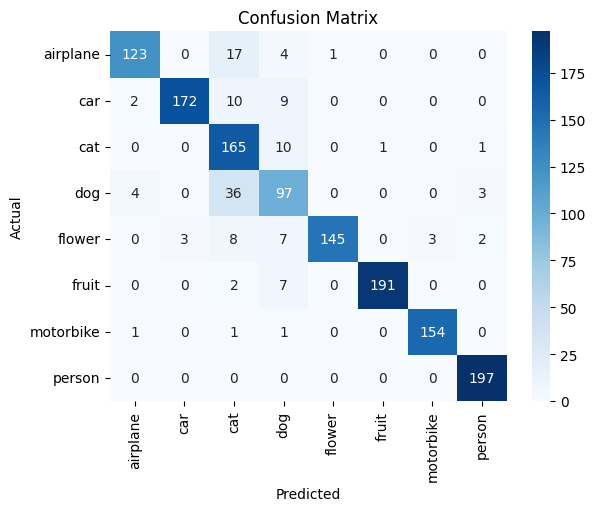

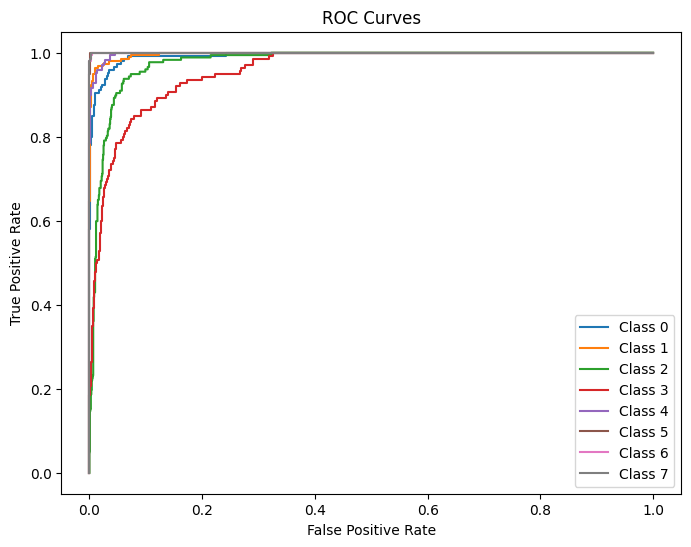

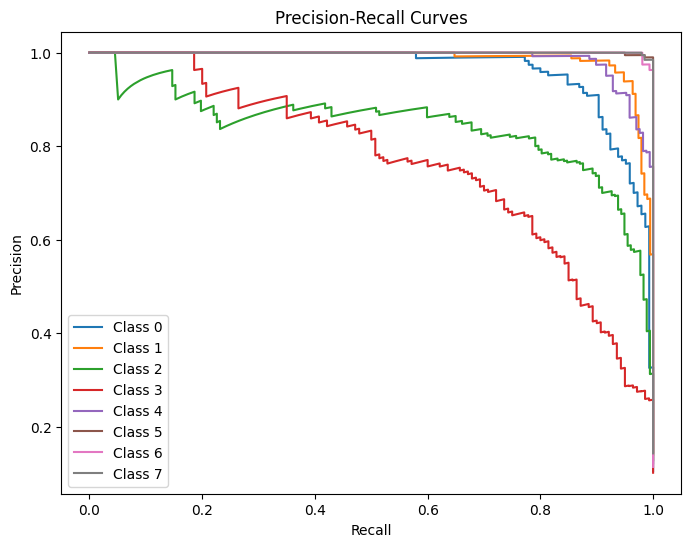

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [6]:

# Evaluate Model
y_true = []
y_pred = []
y_pred_prob = []

for images, labels in val_data:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_pred_prob.extend(preds)
    y_true.extend(np.argmax(labels, axis=1))
    if len(y_true) >= val_data.samples:
        break

report = classification_report(y_true, y_pred, target_names=train_data.class_indices.keys())
print(report)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_data.class_indices.keys(), yticklabels=train_data.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curves
plt.figure(figsize=(8, 6))
for i in range(train_data.num_classes):
    fpr, tpr, _ = roc_curve(np.array(y_true) == i, np.array(y_pred_prob)[:, i])
    plt.plot(fpr, tpr, label=f'Class {i}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

# Precision-Recall Curves
plt.figure(figsize=(8, 6))
for i in range(train_data.num_classes):
    precision, recall, _ = precision_recall_curve(np.array(y_true) == i, np.array(y_pred_prob)[:, i])
    plt.plot(recall, precision, label=f'Class {i}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.show()

# Save Model
model.save("natural_images_classifier.h5")
